In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.stream.shuffle import Bi2Uni
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
rng = "Sobol"

in_dim = 1024
bitwidth = 8
in_mode = "bipolar"
out_mode = "unipolar"
stype = torch.float
btype = torch.float
rtype = torch.float

uBi2Uni = Bi2Uni(stype=stype).to(device)

iVec = ((torch.rand(in_dim)*(2**bitwidth)).round()/(2**bitwidth)).to(device)
start_time = time.time()
oVec = iVec.type(torch.float)
print("--- %s seconds ---" % (((time.time() - start_time))*2**bitwidth))

print("input", iVec)
print("real output", oVec)
        
iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=in_mode, rtype=rtype)().to(device)

iVecRNG = RNG(bitwidth, 1, rng, rtype)().to(device)
iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)

iVecPE = ProgressiveError(iVec, mode=in_mode).to(device)
oVecPE = ProgressiveError(oVec, mode=out_mode).to(device)

with torch.no_grad():
    idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
    start_time = time.time()
    for i in range((2**bitwidth)):
        iBS = iVecBS(idx + i)
        iVecPE.Monitor(iBS)

        oVecU = uBi2Uni(iBS)
        oVecPE.Monitor(oVecU)
    print("--- %s seconds ---" % (time.time() - start_time))
    print("final input error: ", min(iVecPE()[1]), max(iVecPE()[1]))
    print("final output error:", min(oVecPE()[1]), max(oVecPE()[1]))
    print("final output pp:", oVecPE()[0].data)
    print("final output pe:", oVecPE()[1].data)
    print("final output mean error:", oVecPE()[1].mean())
    
    result_pe = oVecPE()[1].cpu().numpy()

--- 0.0 seconds ---
input tensor([0.3125, 0.5039, 0.5273,  ..., 0.2539, 0.4922, 0.2891], device='cuda:0')
real output tensor([0.3125, 0.5039, 0.5273,  ..., 0.2539, 0.4922, 0.2891], device='cuda:0')
--- 0.04501008987426758 seconds ---
final input error:  tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
final output error: tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
final output pp: tensor([0.3125, 0.5000, 0.5312,  ..., 0.2500, 0.4922, 0.2891], device='cuda:0')
final output pe: tensor([ 0.0000, -0.0039,  0.0039,  ..., -0.0039,  0.0000,  0.0000],
       device='cuda:0')
final output mean error: tensor(1.5259e-05, device='cuda:0')


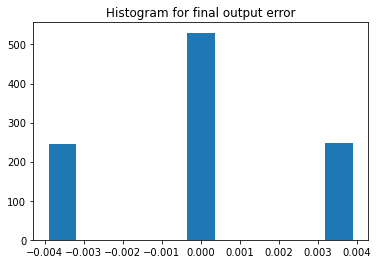

In [5]:
fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for final output error")
plt.show()

In [6]:
print(result_pe)
print(result_pe.argmin(), result_pe.argmax())
print(result_pe[result_pe.argmin()], result_pe[result_pe.argmax()])
print(iVec[result_pe.argmin()], iVec[result_pe.argmax()])

[ 0.         -0.00390625  0.00390625 ... -0.00390625  0.
  0.        ]
1 2
-0.00390625 0.00390625
tensor(0.5039, device='cuda:0') tensor(0.5273, device='cuda:0')
